# Preprocessing for Raccoon Dataset

Preprocessing is an important step in the deep learning process. Because training is time and computationally expensive, we want to perform preprocessing outside of the training loop.

In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import albumentations as A
import albumentations
from albumentations.pytorch import ToTensorV2

### Load Data

In [2]:
data_path = './Data/Racoon Images/images'
raccoon_df = pd.read_csv('./Data/train_labels_.csv')
raccoon_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [3]:
# Sample Image
path = data_path + '/' + raccoon_df.iloc[0]['filename']
img = cv2.imread(path)
img.shape

(194, 259, 3)

In [4]:
# Bounding box for sample image
x0 = raccoon_df.iloc[0]['xmin']
y0 = raccoon_df.iloc[0]['ymin']
x1 = raccoon_df.iloc[0]['xmax']
y1 = raccoon_df.iloc[0]['ymax']
(x0,y0), (x1,y1)

((95, 60), (167, 118))

In [5]:
def display_imgbb(img, xmin, ymin, xmax, ymax):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((xmin,ymin), (xmax - xmin) , (ymax - ymin) , linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

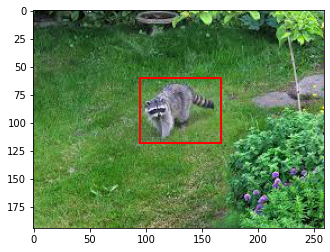

In [6]:
display_imgbb(img,x0,y0,x1,y1)

### Remove Images with >1 raccoon

A basic CNN can only draw one bounding box (more complicated approaches include region proposals and YOLO). To simplify our problem, let's remove images with more than one raccoon which leaves us with 148 images to work with.

In [7]:
# Remove images to >1 raccoon
new = pd.DataFrame(raccoon_df.filename.value_counts() > 1).reset_index()
new = new[new['filename'] == True]
for_removal = list(new['index'].values)
raccoon_df = raccoon_df[~raccoon_df['filename'].isin(for_removal)]
len(raccoon_df)

148

### Scale Images

The CNN model expects inputs of the same shape, thus, resizing both the images and the bounding boxes is necessary for the training loop. Again, saving copies of the resized images locally will help save time during training.

In [9]:
# smallest w,h... so 128x128 should be ok size
raccoon_df['width'].min(), raccoon_df['height'].min()

(178, 154)

In [59]:
# Make a new directory for scaled images
# !mkdir Data/Racoon\ Images/images_rs

In [60]:
# Resize images before training, only needs to be done once
# def resize_img(path, newpath, size):
#     img = cv2.imread(path)
    
#     start = time.time()
#     img = cv2.resize(img, size)
#     end = time.time()
    
#     cv2.imwrite(newpath, img)
#     return end - start

# # resize all of the images
# total_time_resize = 0.0
# for idx in range(len(df)):
#     row = df.iloc[idx]
#     fname = row['filename']
#     path = data_path + '/' + row['filename']
#     newpath = './Data/Racoon Images/images_rs'+'/'+fname
    
#     total_time_resize += resize_img(path, newpath, (image_size, image_size))
# total_time_resize

In [10]:
# Check that rescale worked... looks good!
path = './Data/Racoon Images/images_rs/' + raccoon_df.iloc[0]['filename']
img = cv2.imread(path)
img.shape

(128, 128, 3)

In [11]:
# Rescale bounding box
image_size = 128
raccoon_df['xmin_rs'] = raccoon_df['xmin']*image_size/raccoon_df['width']
raccoon_df['xmax_rs'] = raccoon_df['xmax']*image_size/raccoon_df['width']
raccoon_df['ymin_rs'] = raccoon_df['ymin']*image_size/raccoon_df['height']
raccoon_df['ymax_rs'] = raccoon_df['ymax']*image_size/raccoon_df['height']
raccoon_df

,filename,width,height,class,xmin,ymin,xmax,ymax,xmin_rs,xmax_rs,ymin_rs,ymax_rs
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118,46.949807,82.532819,39.587629,77.855670
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431,0.581818,89.406061,0.296296,127.703704
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127,27.194139,92.366300,22.832432,87.870270
5,raccoon-69.jpg,205,246,raccoon,12,11,188,240,7.492683,117.385366,5.723577,124.878049
6,raccoon-180.jpg,600,400,raccoon,119,21,368,399,25.386667,78.506667,6.720000,127.680000
...,...,...,...,...,...,...,...,...,...,...,...,...
168,raccoon-137.jpg,320,240,raccoon,71,8,304,233,28.400000,121.600000,4.266667,124.266667
169,raccoon-171.jpg,224,225,raccoon,108,21,180,115,61.714286,102.857143,11.946667,65.422222
170,raccoon-190.jpg,259,194,raccoon,78,54,153,135,38.548263,75.613900,35.628866,89.072165
171,raccoon-22.jpg,640,360,raccoon,252,76,466,335,50.400000,93.200000,27.022222,119.111111


In [12]:
# Train/valid split Raccoon
valid_r = raccoon_df.sample(frac=.2)
train_r = raccoon_df.drop(valid_r.index)
len(train_r),len(valid_r)

(118, 30)

## Add Wildlife Images to Dataset

Let's add some images of wildlife like wolves, cheetahs, jaguars to add to our dataset.

Animal Faces Image Data from [here](https://www.kaggle.com/andrewmvd/animal-faces)

### Load Data

In [19]:
# Wildlife Images
data_path = '../DeepLearning_MSDS21/Data/afhq/'

rows = []
for dataset in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{dataset}'):
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label
            row['dataset'] = dataset
        
            # a bit redudant, could build from other data in __getitem__ if wanted
            row['image_path'] = data_path + f'/{dataset}' + f'/{label}'
            rows.append(row)
        
df = pd.DataFrame(rows)
print(len(df))
df.head()

16279


,image_file,label,dataset,image_path
0,pixabay_cat_000455.jpg,cat,train,../DeepLearning_MSDS21/Data/afhq//train/cat
1,pixabay_cat_001993.jpg,cat,train,../DeepLearning_MSDS21/Data/afhq//train/cat
2,pixabay_cat_004633.jpg,cat,train,../DeepLearning_MSDS21/Data/afhq//train/cat
3,pixabay_cat_002242.jpg,cat,train,../DeepLearning_MSDS21/Data/afhq//train/cat
4,pixabay_cat_002524.jpg,cat,train,../DeepLearning_MSDS21/Data/afhq//train/cat


In [20]:
# Select wildlife images, get 148 images to balance raccoon dataset
wild_df = df[(df['label']=='wild') & (df['dataset']=='train')].sample(n=148)
wild_df

,image_file,label,dataset,image_path
13649,flickr_wild_000956.jpg,wild,train,../DeepLearning_MSDS21/Data/afhq//train/wild
12074,flickr_wild_002691.jpg,wild,train,../DeepLearning_MSDS21/Data/afhq//train/wild
11409,pixabay_wild_000419.jpg,wild,train,../DeepLearning_MSDS21/Data/afhq//train/wild
11581,flickr_wild_000283.jpg,wild,train,../DeepLearning_MSDS21/Data/afhq//train/wild
10162,flickr_wild_002231.jpg,wild,train,../DeepLearning_MSDS21/Data/afhq//train/wild
...,...,...,...,...
10772,flickr_wild_003673.jpg,wild,train,../DeepLearning_MSDS21/Data/afhq//train/wild
14113,pixabay_wild_000700.jpg,wild,train,../DeepLearning_MSDS21/Data/afhq//train/wild
12453,flickr_wild_000289.jpg,wild,train,../DeepLearning_MSDS21/Data/afhq//train/wild
11774,pixabay_wild_000024.jpg,wild,train,../DeepLearning_MSDS21/Data/afhq//train/wild


In [21]:
# Select columns of interest and rename to match raccoon df
wild_df = wild_df[['image_file', 'label']].rename(columns={'image_file':'filename', 'label':'class'})
wild_df

,filename,class
13649,flickr_wild_000956.jpg,wild
12074,flickr_wild_002691.jpg,wild
11409,pixabay_wild_000419.jpg,wild
11581,flickr_wild_000283.jpg,wild
10162,flickr_wild_002231.jpg,wild
...,...,...
10772,flickr_wild_003673.jpg,wild
14113,pixabay_wild_000700.jpg,wild
12453,flickr_wild_000289.jpg,wild
11774,pixabay_wild_000024.jpg,wild


In [36]:
wild_df.to_csv('wildlife_train.csv')

### Scale Images

In [26]:
!mkdir ../DeepLearning_MSDS21/Data/afhq/train/wild_rs

In [27]:
#Resize Wildlife images before training
def resize_img(path, newpath, size):
    img = cv2.imread(path)
    
    start = time.time()
    img = cv2.resize(img, size)
    end = time.time()
    
    cv2.imwrite(newpath, img)
    return end - start

# resize all of the images
total_time_resize = 0.0
image_size = 128
for idx in range(len(wild_df)):
    row = wild_df.iloc[idx]
    fname = row['filename']
    data_path = '../DeepLearning_MSDS21/Data/afhq/train/wild'
    path = data_path + '/' + row['filename']
    newpath = data_path + '_rs/'+fname
    
    total_time_resize += resize_img(path, newpath, (image_size, image_size))
total_time_resize

0.014033794403076172

In [30]:
# Check that resize worked
path = data_path + '_rs/' + wild_df.iloc[0]['filename']
img = cv2.imread(path)
img.shape

(128, 128, 3)

In [31]:
# Train/valid split Wildlife
valid_w = wild_df.sample(frac=.2)
train_w = wild_df.drop(valid_w.index)
len(train_w),len(valid_w)

(118, 30)

### Combine the raccoon and wildlife dataframes

In [32]:
# Combine dfs
train = train_r.append(train_w, ignore_index=True)
valid = valid_r.append(valid_w, ignore_index=True)
len(train), len(valid)

(236, 60)

In [33]:
# For wildlife bounding boxes, fill NAs with 0
train[['xmin_rs','ymin_rs','xmax_rs','ymax_rs']] = train[['xmin_rs','ymin_rs','xmax_rs','ymax_rs']].fillna(value=0)
valid[['xmin_rs','ymin_rs','xmax_rs','ymax_rs']] = valid[['xmin_rs','ymin_rs','xmax_rs','ymax_rs']].fillna(value=0)
train

,filename,width,height,class,xmin,ymin,xmax,ymax,xmin_rs,xmax_rs,ymin_rs,ymax_rs
0,raccoon-17.jpg,259.0,194.0,raccoon,95.0,60.0,167.0,118.0,46.949807,82.532819,39.587629,77.855670
1,raccoon-11.jpg,660.0,432.0,raccoon,3.0,1.0,461.0,431.0,0.581818,89.406061,0.296296,127.703704
2,raccoon-60.jpg,273.0,185.0,raccoon,58.0,33.0,197.0,127.0,27.194139,92.366300,22.832432,87.870270
3,raccoon-200.jpg,261.0,193.0,raccoon,107.0,10.0,249.0,166.0,52.475096,122.114943,6.632124,110.093264
4,raccoon-141.jpg,249.0,202.0,raccoon,1.0,1.0,154.0,176.0,0.514056,79.164659,0.633663,111.524752
...,...,...,...,...,...,...,...,...,...,...,...,...
231,flickr_wild_002748.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
232,pixabay_wild_000700.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
233,flickr_wild_000289.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
234,pixabay_wild_000024.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000


In [98]:
train.to_csv('combined_train.csv')
valid.to_csv('combined_valid.csv')

In [16]:
class AnimalDataset(Dataset):
    def __init__(self, df, augment=True):
        # Dataframe with bounding boxes
        self.df = df
        
        # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                albumentations.augmentations.transforms.VerticalFlip(p=.25),
                albumentations.augmentations.transforms.HorizontalFlip(p=.25),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()])
        else:
            self.transforms = A.Compose([
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
        
    def __len__(self):
        return len(self.df) # this only works if 1:1 image:label
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        class_dict = {'wild':0, 'raccoon':1}
        class_label = class_dict[row['class']]
        
        # Create image array
        fname = row['filename']
        if class_label == 1:
            raccoon_path = './Data/Racoon Images/images_rs'
            img_path = raccoon_path + '/' + fname
        else:
            wild_path = '../DeepLearning_MSDS21/Data/afhq/train/wild_rs'
            img_path = wild_path + '/' + fname
        img = cv2.imread(img_path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']   
        
        
        # Get bounding box label
        xmin, ymin = tuple(list(row[['xmin_rs','ymin_rs']].values))
        xmax, ymax = tuple(list(row[['xmax_rs','ymax_rs']].values))
        bbox_label = torch.tensor([xmin,ymin,xmax,ymax]).float()
        
        return img, class_label, bbox_label

In [34]:
train_ds = AnimalDataset(train)
valid_ds = AnimalDataset(valid)

In [35]:
next(iter(train_ds))

(tensor([[[-0.5596, -1.9809, -1.9467,  ...,  0.3309,  0.1254,  0.7077],
          [-0.6452, -2.1179, -1.8097,  ..., -0.4568, -0.0458,  0.2624],
          [-1.3473, -1.7925, -1.7240,  ..., -0.5253, -0.2513, -0.2513],
          ...,
          [-0.0629, -0.4397, -0.1657,  ..., -2.1179, -0.9877, -0.8335],
          [ 0.2111,  0.0398, -0.1314,  ..., -1.7412, -1.8953, -0.6109],
          [-0.0801,  0.0741, -0.0801,  ..., -1.4500, -1.0390,  0.2967]],
 
         [[-0.2500, -1.7031, -1.7031,  ...,  1.3431,  1.0980,  1.6758],
          [-0.3375, -1.8957, -1.5630,  ...,  0.5553,  0.9405,  1.2556],
          [-1.0903, -1.5455, -1.5280,  ...,  0.5203,  0.7829,  0.7654],
          ...,
          [ 0.8354,  0.4503,  0.7479,  ..., -1.3704, -0.0924,  0.1176],
          [ 1.1155,  0.9580,  0.7829,  ..., -0.9328, -0.9678,  0.3978],
          [ 0.8179,  0.9930,  0.8354,  ..., -0.6352, -0.0924,  1.3606]],
 
         [[-0.1661, -1.6127, -1.5256,  ...,  0.7054,  0.6182,  1.2631],
          [-0.2532, -1.7522,

## Data Augmentation

Because our dataset is very small (148 images), we will use the albumentations library to create synthetic data. Transforming the data allows the model to train on a larger variety of images. However, because our validation dataset is mostly upright raccoons, we want to be careful not to morph the training dataset too extensively.

In [64]:
# Let's test on the image from before but after resizing
path = './Data/Racoon Images/images_rs/' + raccoon_df.iloc[0]['filename']
img = cv2.imread(path)

In [69]:
# Bounding box for resized sample image
x0 = raccoon_df.iloc[0]['xmin_rs']
y0 = raccoon_df.iloc[0]['ymin_rs']
x1 = raccoon_df.iloc[0]['xmax_rs']
y1 = raccoon_df.iloc[0]['ymax_rs']
bbox = [[x0,y0,x1,y1,raccoon_df.iloc[0]['class']]]
bbox

[[46.94980694980695,
  39.58762886597938,
  82.53281853281854,
  77.85567010309278,
  'raccoon']]

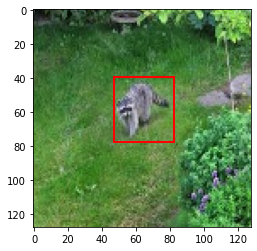

In [45]:
display_imgbb(img, x0,y0, x1,y1)

### Let's try a horizontal flip

In [99]:
# Transformation Pipeline
transform = A.Compose([
    A.HorizontalFlip(p=1),
], bbox_params=A.BboxParams(format='pascal_voc')) # format = [x_min,y_min,x_max,y_max]

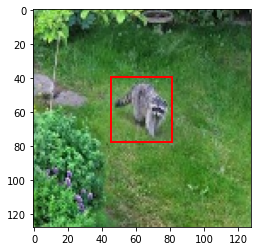

In [100]:
# Perform transformations
transformed = transform(image=img, bboxes=bbox)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']

# Display image
x0,y0, x1,y1,c = transformed_bboxes[0]
display_imgbb(transformed_image, x0,y0, x1,y1)

### Let's try a more complicated pipeline with more randomness

Transformations: random crop, horizontal and vertical flip, rotation, contrast

In [101]:
# Tranformation Pipeline
transform = A.Compose([               
    A.RandomCrop(width=100, height=100, p=.5),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.25),
    A.Rotate(limit = 10, 
             border_mode = cv2.BORDER_CONSTANT, 
             value = 0.0, p = .75),
    A.RandomBrightnessContrast(p=0.5)
    ], bbox_params=A.BboxParams(format='pascal_voc'))

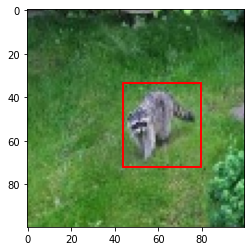

In [102]:
# Trial 1
# Perform transformations
transformed = transform(image=img, bboxes=bbox)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']

# Display Image
x0,y0, x1,y1,c = transformed_bboxes[0]
display_imgbb(transformed_image, x0,y0, x1,y1)

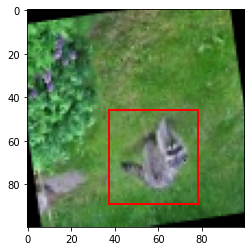

In [103]:
# Trial 2
# Perform transformations
transformed = transform(image=img, bboxes=bbox)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']

# Display Image
x0,y0, x1,y1,c = transformed_bboxes[0]
display_imgbb(transformed_image, x0,y0, x1,y1)